In [1]:
#setup
data_dir='../../Data/Weather'
!ls $data_dir
state='NY'
m='SNWD'

CA.parquet                        US_Weather_BBSSBBSS.csv.gz
CA.tgz                            US_Weather_BBSSBBSS.parquet
Depickle dist_to_coast.ipynb      US_Weather_SSSSBBBB.csv
NY.parquet                        US_Weather_SSSSBBBB.csv.gz
NY.tgz                            US_stations.tsv
RI.parquet                        Weather_Stations.parquet
RI.tgz                            combine station information.ipynb
STAT_NY.pickle                    decon_SSSSBBBB_SNWD.parquet
STAT_RI.pickle.gz                 info
STAT_SSSSBBBB.pickle.gz           spark-warehouse
US_Weather_BBSSBBSS.csv


## Reconstruction using top eigen-vectors

For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.20.3 	required version>=0.19.2

     numpy as    np 	version=1.13.3 	required version>=1.12.0

   sklearn as    sk 	version=0.19.1 	required version>=0.18.1

module urllib has no version
   pyspark as pyspark 	version=2.2.1 	required version>=2.1.0

ipywidgets as ipywidgets 	version=7.0.0 	required version>=6.0.0



In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print('keys from STAT=',measurements)

keys from STAT= dict_keys(['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS'])


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [7]:
#read data
filename=data_dir+'/%s.parquet'%state
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.Measurement==m)
df.show(5)

+-----------+-----------+----+--------------------+-----+
|    Station|Measurement|Year|              Values|State|
+-----------+-----------+----+--------------------+-----+
|USC00303452|       SNWD|1917|[00 7E 00 7E 00 7...|   NY|
|USC00303452|       SNWD|1920|[00 7E 00 7E 00 7...|   NY|
|USC00303452|       SNWD|1921|[F0 57 60 56 60 5...|   NY|
|USC00303452|       SNWD|1928|[00 7E 00 7E 00 7...|   NY|
|USC00303452|       SNWD|1929|[00 7E 00 7E 00 7...|   NY|
+-----------+-----------+----+--------------------+-----+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

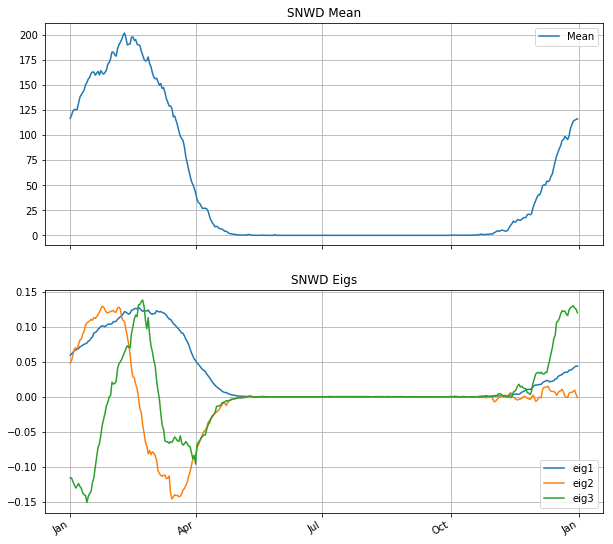

In [8]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,10));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])
fig.savefig('r_figures/SNWD_mean_eigs')

In [9]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

### plot the percent of residual variance on average

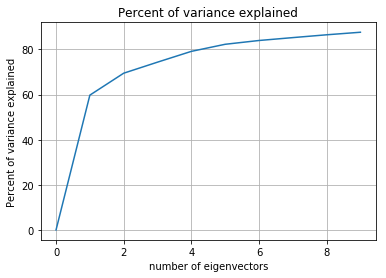

In [10]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [11]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [12]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print('before filter',df2.count())
df3=df2.filter(df2.res_mean<1)
print('after filter',df3.count())

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 3.0 failed 1 times, most recent failure: Lost task 0.0 in stage 3.0 (TID 3, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/yoavfreund/spark-2.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/sql/types.py", line 1504, in __getattr__
    idx = self.__fields__.index(item)
ValueError: 'vector' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/yoavfreund/spark-2.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 177, in main
    process()
  File "/Users/yoavfreund/spark-2.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 172, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/yoavfreund/spark-2.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/Users/yoavfreund/spark-2.2.1-bin-hadoop2.7/python/pyspark/rdd.py", line 1339, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-11-f06a859a6a60>", line 12, in decompose
  File "/Users/yoavfreund/spark-2.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/sql/types.py", line 1509, in __getattr__
    raise AttributeError(item)
AttributeError: vector

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:338)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1517)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1505)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1504)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1504)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1732)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1687)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1676)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:630)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2029)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2050)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2069)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:455)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:483)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/yoavfreund/spark-2.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/sql/types.py", line 1504, in __getattr__
    idx = self.__fields__.index(item)
ValueError: 'vector' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/yoavfreund/spark-2.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 177, in main
    process()
  File "/Users/yoavfreund/spark-2.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 172, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/yoavfreund/spark-2.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/Users/yoavfreund/spark-2.2.1-bin-hadoop2.7/python/pyspark/rdd.py", line 1339, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-11-f06a859a6a60>", line 12, in decompose
  File "/Users/yoavfreund/spark-2.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/sql/types.py", line 1509, in __getattr__
    raise AttributeError(item)
AttributeError: vector

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:338)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [21]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

In [22]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            #_title='%3.2f,r1=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            _title='c1=%3.2f,r1=%3.2f'\
                    %(row['coeff_1'],row['res_1'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [23]:
df4=df3.filter(df3.res_3<0.4).sort(df3.coeff_3)
rows=df4.take(12)
df4.select('coeff_3','res_3').show(10)

+-------------------+-------------------+
|            coeff_3|              res_3|
+-------------------+-------------------+
|-2110.0314623995782|0.20384994133204803|
|  -1699.80422268191|0.05460837218317053|
|-1594.3282282801629|0.08848097180179156|
|-1507.7025445150573| 0.2436064338889107|
| -1452.464006377609|0.11950866429095269|
|-1408.4843217890364|0.16820681084085648|
|-1211.8323997309876|0.26758002478047643|
| -1080.923242249827| 0.2712323361486209|
|-1055.2174465334297|0.14336504639629977|
|-1046.9837013689053|0.24226825441110592|
+-------------------+-------------------+
only showing top 10 rows



/Users/yoavfreund/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


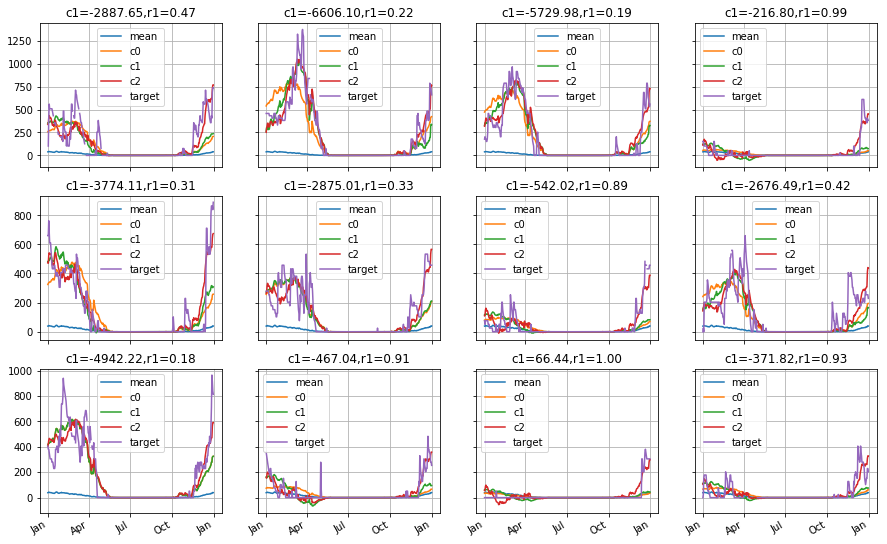

In [24]:
plot_recon_grid(rows)
savefig('r_figures/SNWD_grid_neg_coeff3.png')

In [25]:
df5=df3.filter(df3.res_3<0.4).sort(df3.coeff_3,ascending=False)
rows=df5.take(12)
df5.select('coeff_3','res_3').show(4)

+------------------+-------------------+
|           coeff_3|              res_3|
+------------------+-------------------+
| 1621.708167301692| 0.0339454659254009|
|1558.1240353915246|0.04572780175270626|
|1322.8427149086501| 0.3178690413871973|
|1244.5944855772364|0.09075516407916882|
+------------------+-------------------+
only showing top 4 rows



/Users/yoavfreund/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


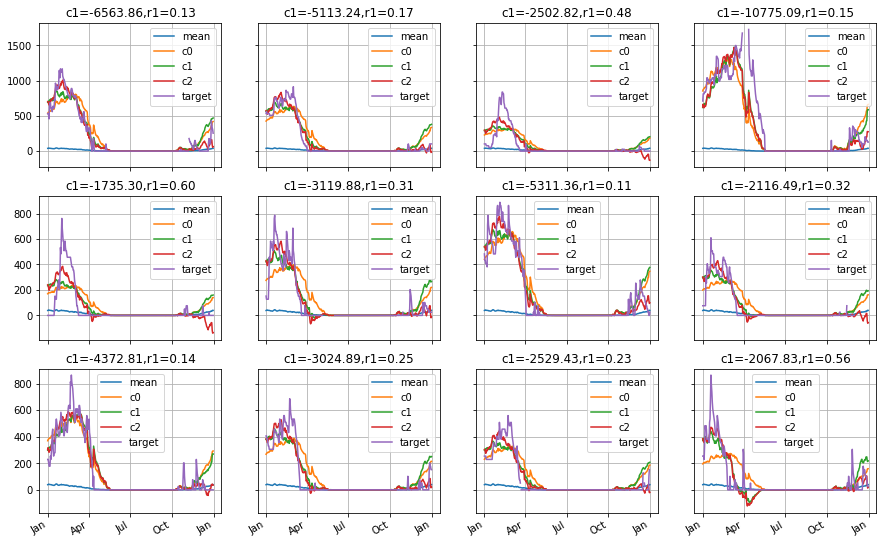

In [26]:
plot_recon_grid(rows)
savefig('r_figures/SNWD_grid_Pos_coeff3.png')

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

residual normalized norm  after mean: 0.91897791011
residual normalized norm  after mean + top eigs: [ 0.12580467  0.08728215  0.03394547]


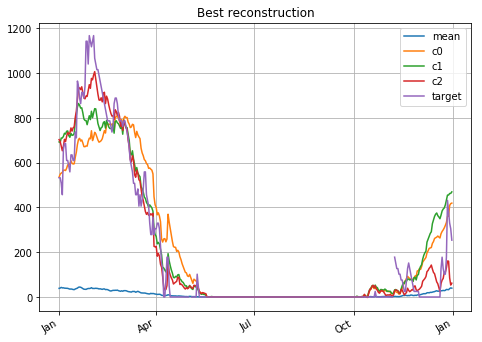

A Jupyter Widget

In [28]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print('residual normalized norm  after mean:',res[0])
print('residual normalized norm  after mean + top eigs:',res[1:])

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [29]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

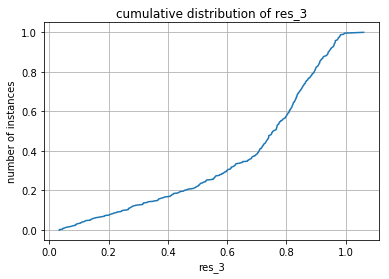

In [30]:
plot_CDF('res_3')
savefig('r_figures/SNWD_res_3_CDF.png')

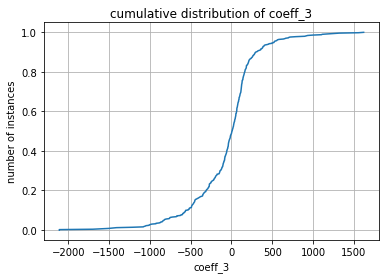

In [31]:
plot_CDF('coeff_3')
savefig('r_figures/SNWD_coeff_3_CDF.png')

In [32]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [33]:
!du -sh $data_dir/*.parquet

4.2M	../../Data/Weather/US_Weather_BBSSBBSS.parquet
3.8M	../../Data/Weather/US_Weather_SSSSBBBB.parquet
2.3M	../../Data/Weather/decon_SSSSBBBB_SNWD.parquet
